# Методы поиска сообществ

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

from sklearn.metrics import accuracy_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import mutual_info_score
from sklearn.metrics import jaccard_score
from sklearn.metrics.cluster import normalized_mutual_info_score

Рассмотрим пример, для которого известна структура сообществ:

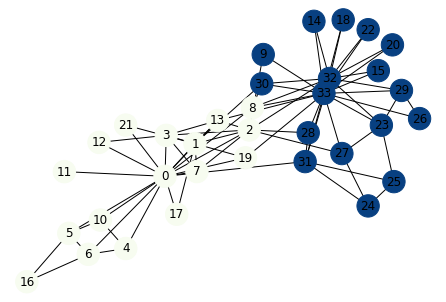

In [13]:
KC = nx.karate_club_graph()
from itertools import count
groups = set(nx.get_node_attributes(KC,'club').values())
mapping = dict(zip(sorted(groups),count()))
nodes = KC.nodes()
colors = [mapping[nx.get_node_attributes(KC, 'club')[n]] for n in nodes]
nx.draw(KC,node_size=500,with_labels=True,node_color=colors,cmap='GnBu')

* напишем функцию, вычисляющую матрицу схожести $X$ вершин простого графа, элементы матрицы:
$$
x_{ij}=\frac{J(i,j)+A_{ij}}{min(k_i,k_j)+1-A_{ij}},
$$
$J(i,j)$-число общих соседей вершин $i$ и $j$:

In [14]:
def similarity_matrix(G,nodelist=None):
    if (nodelist==None):
        nodelist=list(G.nodes)
    Smatrix=np.zeros([len(nodelist), len(nodelist)])
    for i in range(len(nodelist)):
        for j in range(i+1, len(nodelist)):
            node1,node2=nodelist[i],nodelist[j]
            Smatrix[i,j]=(len(set(G[node1]) & set(G[node2]))+int(G.has_edge(node1,node2)))/(np.min([len(G[node1]),len(G[node2])])
                                                                                          +1-int(G.has_edge(node1,node2)))
            Smatrix[j,i]=Smatrix[i,j]
    return Smatrix

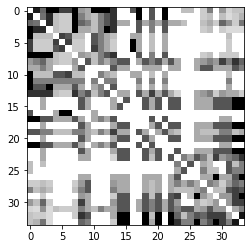

In [15]:
plt.imshow(similarity_matrix(KC,nodelist=None), cmap='binary')

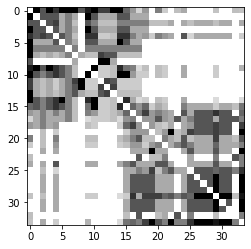

In [16]:
plt.imshow(similarity_matrix(KC,nodelist=list(np.argsort(colors))), cmap='binary') 

In [17]:
from sklearn.cluster import AgglomerativeClustering

In [18]:
communities= AgglomerativeClustering(linkage='average')

In [19]:
X=similarity_matrix(KC,nodelist=None)
communities.fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:468: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=2)

In [20]:
y_pred=communities.labels_
y_true=np.array(colors)
print(y_pred)
print(y_true)

[0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

[[16  1]
 [ 0 17]]


In [22]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.9705882352941176


### Дендрограмма 

In [23]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:468: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


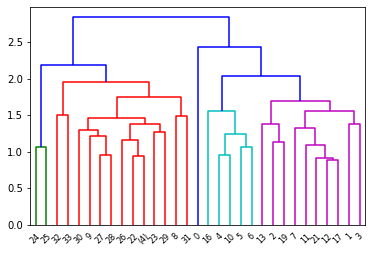

In [24]:
communities2=AgglomerativeClustering(linkage='average',distance_threshold=0, n_clusters=None)
communities2.fit(X)
plot_dendrogram(communities2, truncate_mode='level', p=7)

# Другие метрики качества

### Матрица попарных ошибок:
$$
A=\begin{pmatrix}
 a_{00} &  a_{01}\\
a_{10}& a_{11}
\end{pmatrix}	
$$

Hассмотрим всевоозможные пары вершин:
* $a_{00}$ - количество пар, относящиеся к одному сообществу и в первом и во втором разбиениях;
* $a_{01}$ - количество пар, относящиеся к одному сообществу в первом разбиении и к разным во втором разбиении;
* $a_{10}$ - количество пар, относящиеся к одному сообществу во втором разбиении и к разным во первом разбиении;
* $a_{11}$ - количество пар, относящиеся к разным сообществам и в первом и во втором разбиениях;

Метрики основанные на матрице A:

1) Rand индекс
$$
R=\frac{a_{00}+a_{11}}{a_{00}+a_{01}+a_{10}+a_{11}}
$$
2) Jaccard индекс
$$
J=\frac{a_{00}}{a_{00}+a_{01}+a_{10}}
$$

### Mutual information
$$
MI=H(UV)-H(U|V)-H(U|V),
$$
$H(UV)$-совместная энтропия, $H(U|V)$,$H(V|U)$ - условные энтропии;
$$
NMI=\frac{MI}{mean(H(U),H(V))}
$$

In [25]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score

In [26]:
print(mutual_info_score(y_pred, y_true))
print(normalized_mutual_info_score(y_pred, y_true))

0.5795570395842015
0.8371694628777809


## Тестирование модели 

Одним из бенчмарков для тестирования методов выделения сообществ является блочно-стохастическая сеть. Рассмотрим генератор двухкластерной сети с внутрикластерной вероятноностью связи $p_{in}$ и межкластерной вероятностью $p_{out}$, размеры блоков одинаковы:

In [27]:
def block_model(n, p_in, p_out):
    A1=np.random.binomial(1, p_in, size=[n,n]) # for edges inside clusters
    A2=np.random.binomial(1, p_in, size=[n,n])
    for i in range(n):
        A1[i,i]=0
        A2[i,i]=0
        for j in range(i+1,n):
            A1[i,j]=A1[j,i]
            A2[i,j]=A2[j,i]
        
    B=np.random.binomial(1, p_out, size=[n,n]) # for edges between clusters
    A=np.block([[A1,B],[B,A2]])
    G=nx.from_numpy_matrix(A)
    return G

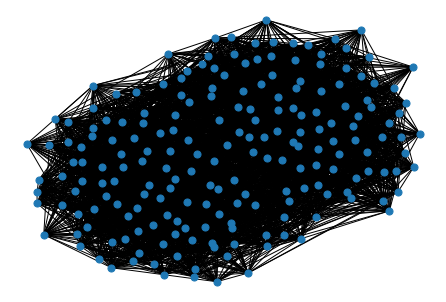

In [28]:
bG=block_model(100,0.3,0.05)
nx.draw(bG,node_size=50)

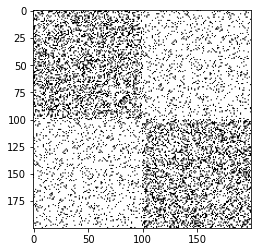

In [29]:
plt.imshow(nx.adjacency_matrix(bG).todense().getA(), cmap='binary')

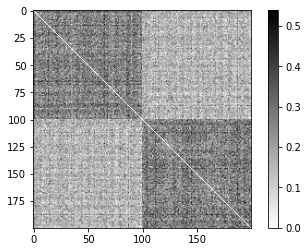

In [30]:
plt.imshow(similarity_matrix(bG), cmap='binary')
plt.colorbar()

## Задача
* рассмотрим двухкластерную модель с различным $p_{out} \in [0, p_{in}]$. 

* постройте 1) долю верных предсказаний (2 балла) 2) взаимную информацию MI (2 балла) ; 3) Jaccard индекс (4 балла) от параметра $\mu$ (mixing parameter)
 $$
 \mu=\frac{p_{out}}{p_{in}+p_{out}}
 $$

Обратите внимание, что для 1) важна разметка кластеров (можно разметить 1 блок - '0', второй - '1' и наоборот), нужно подобрать так, чтобы верных предсказаний было наибольшее число. 

In [38]:
X=similarity_matrix(bG,nodelist=None)
communities.fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:468: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=2)

In [39]:
y1=communities.labels_
y2=[0]*100+[1]*100

In [40]:
print(confusion_matrix(y1, y2))

[[  0 100]
 [100   0]]


In [41]:
communities.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [44]:
def accuracy(y_true, y_pred):
  labels = np.unique(y_pred)
  pred_relabeled = []
  for label in y_pred:
    if label == labels[0]:
      pred_relabeled.append(labels[1])
    else:
      pred_relabeled.append(labels[0])

  return max(accuracy_score(y_true, y_pred), accuracy_score(y_true,
                                                            pred_relabeled))

In [45]:
p_in = 1.0

accuracys, MIs, jaccards, mus = [], [], [], []

for p_out in np.linspace(0, p_in, 100) :
    communities = AgglomerativeClustering(linkage='average')
    X = similarity_matrix(block_model(100, p_in, p_out), nodelist=None)
    communities.fit(X)
    y1 = communities.labels_
    y2 = [0] * 100 + [1] * 100

    accuracys.append(accuracy(y2, y1))
    MIs.append(mutual_info_score(y2, y1))
    jaccards.append(jaccard_score(y2, y1))
    mus.append(p_out / (p_in + p_out))

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:468: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:468: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:468: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:468: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix l

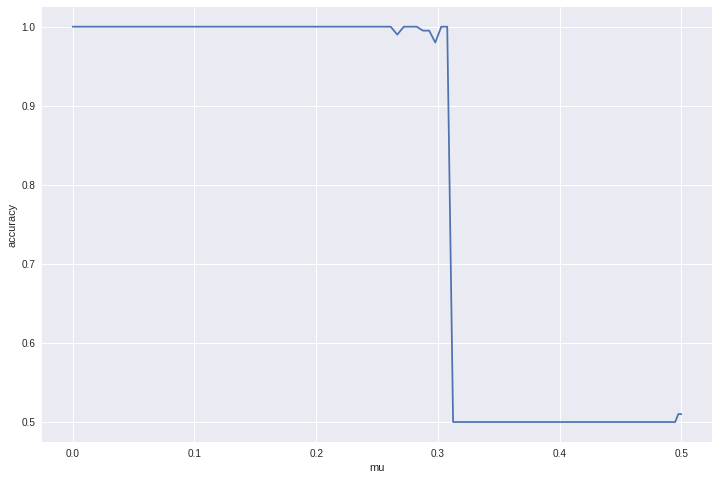

In [47]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(12, 8))
plt.plot(mus, accuracys)
plt.xlabel('mu')
plt.ylabel('accuracy');

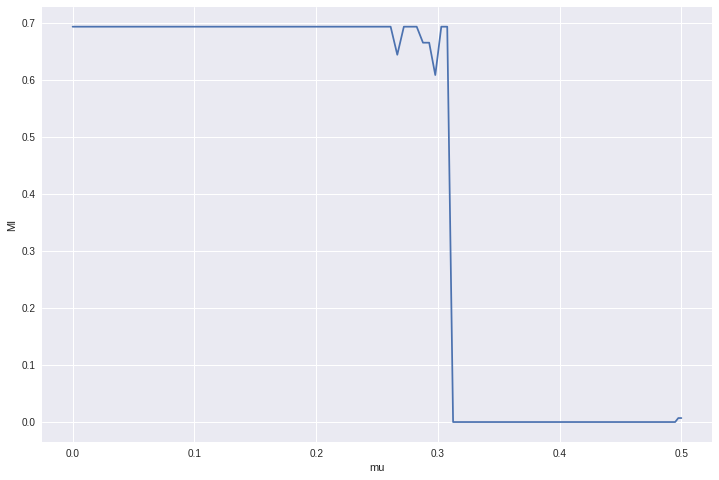

In [53]:
fig = plt.figure(figsize=(12, 8))
plt.plot(mus, MIs)
plt.xlabel('mu')
plt.ylabel('MI');

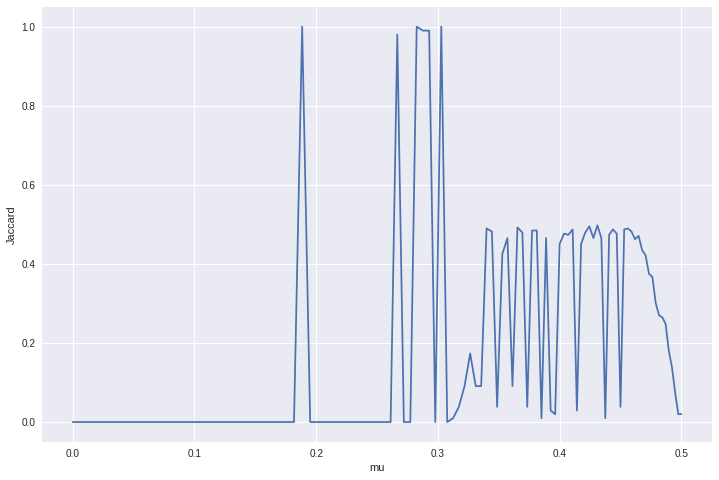

In [52]:
fig = plt.figure(figsize=(12, 8))
plt.plot(mus, jaccards)
plt.xlabel('mu')
plt.ylabel('Jaccard');